In [0]:
!pip3 install torch torchvision tqdm matplotlib scikit-image

In [0]:
!rm -rf ./ccpd5000/ && rm ccpd5000.tar.gz
!wget https://github.com/amoshyc/cvlab-2019w-project/releases/download/v0.1/ccpd5000.tar.gz
!tar zxf ccpd5000.tar.gz
!ls ccpd5000/**/*.jpg | wc -l

In [0]:
from pathlib import Path

img_dir = Path('./ccpd5000/train/')
img_paths = img_dir.glob('*.jpg')
img_paths = sorted(list(img_paths))

print(len(img_paths))

name = img_paths[0].name
print(name)

token = name.split('-')[3]
print(token)

token = token.replace('&', '_')
print(token)

values = token.split('_')
print(values)

values = [float(val) for val in values]
print(values)

In [0]:
import warnings

import torch
import numpy as np
from PIL import Image, ImageDraw
from skimage import util
from skimage.transform import ProjectiveTransform, warp

def draw_kpts(img, kpts, c='red', r=2.0):
    '''Draw keypoints on image.
    Args:
        img: (PIL.Image) will be modified
        kpts: (FloatTensor) keypoints in xy format, sized [8,]
        c: (PIL.Color) color of keypoints, default to 'red'
        r: (float) radius of keypoints, default to 2.0
    Return:
        img: (PIL.Image) modified image
    '''
    draw = ImageDraw.Draw(img)
    kpts = kpts.view(4, 2)
    kpts = kpts * torch.FloatTensor(img.size)
    kpts = kpts.numpy().tolist()
    for (x, y) in kpts:
        draw.ellipse([x - r, y - r, x + r, y + r], fill=c)
    return img


def draw_plate(img, kpts):
    '''Perspective tranform and draw the plate indicated by kpts to a 96x30 rectangle.
    Args:
        img: (PIL.Image) will be modified
        kpts: (FloatTensor) keypoints in xy format, sized [8,]
    Return:
        img: (PIL.Image) modified image
    Reference: http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_geometric.html
    '''
    src = np.float32([[96, 30], [0, 30], [0, 0], [96, 0]])
    dst = kpts.view(4, 2).numpy()
    dst = dst * np.float32(img.size)

    transform = ProjectiveTransform()
    transform.estimate(src, dst)
    with warnings.catch_warnings(): # surpress skimage warning
        warnings.simplefilter("ignore")
        warped = warp(np.array(img), transform, output_shape=(30, 96))
        warped = util.img_as_ubyte(warped)
    plate = Image.fromarray(warped)
    img.paste(plate)
    return img

In [0]:
from PIL import Image
from tqdm import tqdm
from pathlib import Path

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import functional as tf

class CCPD5000:
  def __init__(self, img_dir):
    self.img_dir = Path(img_dir)
    self.img_paths = self.img_dir.glob('*.jpg')
    self.img_paths = sorted(list(self.img_paths))
    
  def __len__(self):
    return len(self.img_paths)
  
  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    
    # load image
    img = Image.open(img_path)
    W, H = img.size
    img = img.convert('RGB')
    img = img.resize((192, 320))
    img = tf.to_tensor(img)
    
    # parse annotation
    name = img_path.name
    token = name.split('-')[3]
    token = token.replace('&', '_')
    kpt = [float(val) for val in token.split('_')]
    kpt = torch.tensor(kpt) # [8,]
    kpt = kpt.view(4, 2) # [4, 2]
    kpt = kpt / torch.FloatTensor([W, H])
    kpt = kpt.view(-1) # [8,]
    
    return img, kpt
  

train_set = CCPD5000('./ccpd5000/train')
print(len(train_set))

img, kpt = train_set[-1]
print(img.size())
print(kpt.size())

In [0]:
import torch
from torch import nn
from torch.nn import functional as F


class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.conv1 = nn.Conv2d(cin, cout, (3, 3), padding=1)
        self.conv2 = nn.Conv2d(cout, cout, (3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(cout)
        self.bn2 = nn.BatchNorm2d(cout)
        self.act1 = nn.LeakyReLU()
        self.act2 = nn.LeakyReLU()

    def forward(self, x):
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.act1(self.bn2(self.conv2(x)))
        return x


class CCPDRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            ConvBlock(3, 32),
            nn.MaxPool2d((8, 8)),
            ConvBlock(32, 32),
            nn.MaxPool2d((4, 4)),
            ConvBlock(32, 64),
            nn.MaxPool2d((2, 2)),
            ConvBlock(64, 64),
            nn.MaxPool2d((2, 2)),
        )
        self.regressor = nn.Sequential(
            nn.Linear(128, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 8),
            nn.Sigmoid(),
        )

    def forward(self, x):
        N = x.size(0)
        x = self.features(x)
        x = x.view(N, -1) # i.e. Flatten
        x = self.regressor(x)
        return x


if __name__ == '__main__':
    device = 'cuda'
    model = CCPDRegressor().to(device)
    img_b = torch.rand(16, 3, 320, 192).to(device)
    out_b = model(img_b)
    print(out_b.size())

In [11]:
import json
import random
import numpy as np
from tqdm import tqdm
from pathlib import Path
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.utils import save_image
from torch.utils.data import Subset, ConcatDataset, DataLoader
from torchvision.transforms import functional as tf

# For reproducibility
# Set before loading model and dataset
seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

#import util
#from dataset import CCPD5000
#from model import CCPDRegressor

train_set = CCPD5000('./ccpd5000/train/')
valid_set = CCPD5000('./ccpd5000/valid/')
visul_set = ConcatDataset([
    Subset(train_set, random.sample(range(len(train_set)), 32)),
    Subset(valid_set, random.sample(range(len(valid_set)), 32)),
])
train_loader = DataLoader(train_set, 32, shuffle=True, num_workers=3)
valid_loader = DataLoader(valid_set, 32, shuffle=False, num_workers=1)
visul_loader = DataLoader(visul_set, 32, shuffle=False, num_workers=1)

device = 'cuda'
model = CCPDRegressor().to(device)
criterion = nn.L1Loss().to(device)
optimizer = torch.optim.Adam(model.parameters())

log_dir = Path('./log/') / f'{datetime.now():%Y.%m.%d-%H:%M:%S}'
log_dir.mkdir(parents=True)
print(log_dir)
history = {
    'train_mae': [],
    'valid_mae': [],
    'train_mse': [],
    'valid_mse': [],
}


def train(pbar):
    model.train()
    mae_steps = []
    mse_steps = []

    for img_b, kpt_b in iter(train_loader):
        img_b = img_b.to(device)
        kpt_b = kpt_b.to(device)

        optimizer.zero_grad()
        pred_b = model(img_b)
        loss = criterion(pred_b, kpt_b)
        loss.backward()
        optimizer.step()

        mae = loss.detach().item()
        mse = F.mse_loss(pred_b.detach(), kpt_b.detach()).item()
        mae_steps.append(mae)
        mse_steps.append(mse)

        pbar.set_postfix(mae=mae, mse=mse)
        pbar.update(img_b.size(0))

    avg_mae = sum(mae_steps) / len(mae_steps)
    avg_mse = sum(mse_steps) / len(mse_steps)
    pbar.set_postfix(avg_mae=f'{avg_mae:.5f}', avg_mse=f'{avg_mse:.5f}')
    history['train_mae'].append(avg_mae)
    history['train_mse'].append(avg_mse)


def valid(pbar):
    model.eval()
    mae_steps = []
    mse_steps = []

    for img_b, kpt_b in iter(valid_loader):
        img_b = img_b.to(device)
        kpt_b = kpt_b.to(device)
        pred_b = model(img_b)
        loss = criterion(pred_b, kpt_b)

        mae = loss.detach().item()
        mse = F.mse_loss(pred_b.detach(), kpt_b.detach()).item()
        mae_steps.append(mae)
        mse_steps.append(mse)

        pbar.set_postfix(mae=mae, mse=mse)
        pbar.update(img_b.size(0))

    avg_mae = sum(mae_steps) / len(mae_steps)
    avg_mse = sum(mse_steps) / len(mse_steps)
    pbar.set_postfix(avg_mae=f'{avg_mae:.5f}', avg_mse=f'{avg_mse:.5f}')
    history['valid_mae'].append(avg_mae)
    history['valid_mse'].append(avg_mse)


def visul(pbar, epoch):
    model.eval()
    epoch_dir = log_dir / f'{epoch:03d}'
    epoch_dir.mkdir()
    for img_b, kpt_b in iter(visul_loader):
        pred_b = model(img_b.to(device)).cpu()
        for img, pred_kpt, true_kpt in zip(img_b, pred_b, kpt_b):
            img = tf.to_pil_image(img)
            vis = draw_plate(img, pred_kpt)
            vis = draw_kpts(vis, true_kpt, c='orange')
            vis = draw_kpts(vis, pred_kpt, c='red')
            vis.save(epoch_dir / f'{pbar.n:03d}.jpg')
            pbar.update()


def log(epoch):
    with (log_dir / 'metrics.json').open('w') as f:
        json.dump(history, f)

    fig, ax = plt.subplots(2, 1, figsize=(6, 6), dpi=100)
    ax[0].set_title('MAE')
    ax[0].plot(range(epoch + 1), history['train_mae'], label='Train')
    ax[0].plot(range(epoch + 1), history['valid_mae'], label='Valid')
    ax[0].legend()
    ax[1].set_title('MSE')
    ax[1].plot(range(epoch + 1), history['train_mse'], label='Train')
    ax[1].plot(range(epoch + 1), history['valid_mse'], label='Valid')
    ax[1].legend()
    fig.savefig(str(log_dir / 'metrics.jpg'))
    plt.close()

    if torch.tensor(history['valid_mse']).argmin() == epoch:
        torch.save(model.state_dict(), str(log_dir / 'model.pth'))

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
for epoch in range(20):
    print('Epoch', epoch, flush=True)
    scheduler.step()
    with tqdm(total=len(train_set), desc='  Train') as pbar:
        train(pbar)

    with torch.no_grad():
        with tqdm(total=len(valid_set), desc='  Valid') as pbar:
            valid(pbar)
        with tqdm(total=len(visul_set), desc='  Visul') as pbar:
            visul(pbar, epoch)
        log(epoch)


log/2019.02.09-13:15:57
Epoch 0


  Visul: 100%|██████████| 64/64 [00:03<00:00, 19.05it/s]


Epoch 1


  Visul: 100%|██████████| 64/64 [00:03<00:00, 17.96it/s]


Epoch 2


  Visul: 100%|██████████| 64/64 [00:03<00:00, 18.57it/s]


Epoch 3


  Visul: 100%|██████████| 64/64 [00:03<00:00, 19.65it/s]


Epoch 4


  Visul: 100%|██████████| 64/64 [00:03<00:00, 24.57it/s]


Epoch 5


  Visul: 100%|██████████| 64/64 [00:03<00:00, 19.32it/s]


Epoch 6


  Visul: 100%|██████████| 64/64 [00:03<00:00, 19.20it/s]


Epoch 7


  Visul: 100%|██████████| 64/64 [00:03<00:00, 18.95it/s]


Epoch 8


  Visul: 100%|██████████| 64/64 [00:03<00:00, 18.94it/s]


Epoch 9


  Visul: 100%|██████████| 64/64 [00:03<00:00, 19.41it/s]


Epoch 10


  Visul: 100%|██████████| 64/64 [00:03<00:00, 19.24it/s]


Epoch 11


  Visul: 100%|██████████| 64/64 [00:03<00:00, 19.55it/s]


Epoch 12


  Visul: 100%|██████████| 64/64 [00:03<00:00, 24.28it/s]


Epoch 13


  Visul: 100%|██████████| 64/64 [00:03<00:00, 18.41it/s]


Epoch 14


  Visul: 100%|██████████| 64/64 [00:03<00:00, 19.23it/s]


Epoch 15


  Visul: 100%|██████████| 64/64 [00:03<00:00, 19.70it/s]


Epoch 16


  Visul: 100%|██████████| 64/64 [00:03<00:00, 15.87it/s]


Epoch 17


  Visul: 100%|██████████| 64/64 [00:03<00:00, 19.11it/s]


Epoch 18


  Visul: 100%|██████████| 64/64 [00:03<00:00, 18.85it/s]


Epoch 19


  Visul: 100%|██████████| 64/64 [00:03<00:00, 19.19it/s]


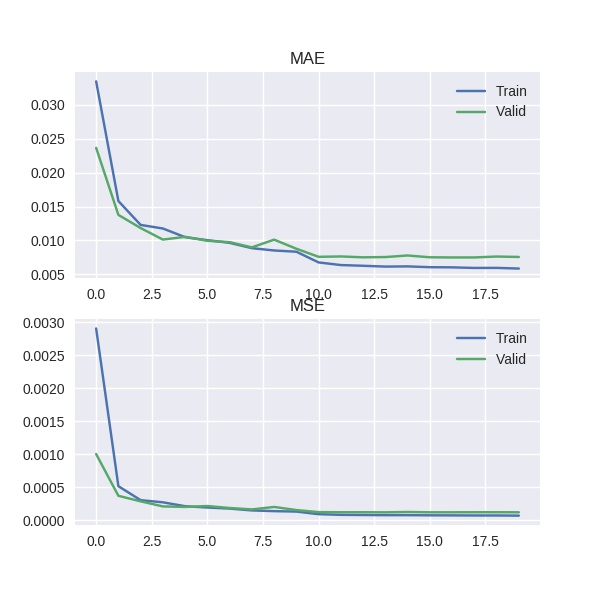

In [12]:
from IPython import display
display.Image(str(log_dir / 'metrics.jpg'))

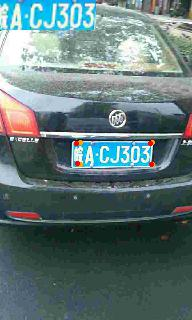

In [13]:
display.Image(str(log_dir / '019' / '013.jpg'))

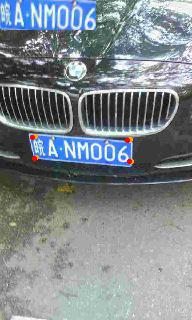

In [14]:
display.Image(str(log_dir / '019' / '055.jpg'))

In [15]:
from pathlib import Path
from datetime import datetime
import pandas as pd
from tqdm import tqdm
from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import functional as tf

#import util
#from model import CCPDRegressor


class CCPDTest:
    def __init__(self, img_dir, img_size):
        img_paths = Path(img_dir).glob('*.jpg')
        self.img_paths = sorted(list(img_paths))
        self.img_size = img_size

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = img.resize(self.img_size)
        img = tf.to_tensor(img)
        return img


test_set = CCPDTest('ccpd5000/test/', (192,320))
print(len(test_set))
test_loader = DataLoader(test_set, 32, shuffle=False, num_workers=2)

device = 'cuda'
model = CCPDRegressor().to(device)
model.load_state_dict(torch.load('log/2019.02.09-13:15:57/model.pth'))
model.eval()

log_dir = Path('./test/') / f'{datetime.now():%Y.%m.%d-%H:%M:%S}'
log_dir.mkdir(parents=True)
print(log_dir)

def test(pbar):
    anns = []
    for img_b in iter(test_loader):
        kpt_b = model(img_b.to(device)).cpu()

        for img, kpt in zip(img_b, kpt_b):
            img = tf.to_pil_image(img)
            vis = draw_plate(img, kpt)
            vis = draw_kpts(vis, kpt, c='red')
            vis.save(log_dir / f'{pbar.n:03d}_vis.jpg')

            anns.append([f'{pbar.n:03d}.jpg', *kpt.numpy().tolist()])
            pbar.update()
    #print(anns)        
    return pd.DataFrame(anns)


with torch.no_grad():
    with tqdm(total=len(test_set)) as pbar:
        df_pred = test(pbar)
   # print(df_pred)
    df_pred.columns = ['name', 'BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y']
    df_pred.to_csv(log_dir / 'test_pred.csv', float_format='%.5f', index=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

1000
test/2019.02.09-14:19:12


100%|██████████| 1000/1000 [00:42<00:00, 23.32it/s]


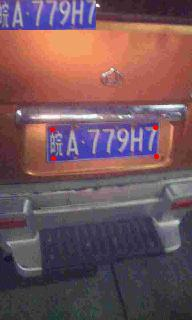

In [19]:
display.Image(str(log_dir / '028_vis.jpg'))

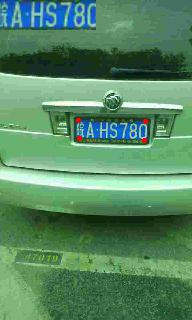

In [20]:
display.Image(str(log_dir / '994_vis.jpg'))